<h2 style="color:blue" align="center">Handwritten digits classification using neural network</h2>
In this notebook we will classify handwritten digits using a simple neural network which has only input and output layers. We will than add a hidden layer and see how the performance of the model improves

In [81]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

load dataset [api](https://pytorch.org/vision/stable/datasets.html)

In [82]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Using downloaded and verified file: ../data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw
Using downloaded and verified file: ../data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw
Using downloaded and verified file: ../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Widget Javascript not detected.  It may not be installed or enabled properly.


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [83]:
len(training_data)

60000

In [84]:
len(test_data)

10000

In [85]:
training_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [86]:
training_data.data[0].shape

torch.Size([28, 28])

In [87]:
training_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

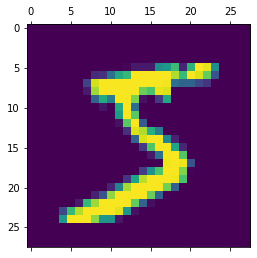

In [88]:
%matplotlib inline
plt.matshow(training_data.data[0])

In [89]:
training_data.targets[0]

tensor(5)

In [90]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [91]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


Using cpu device
NeuralNetwork(
  (flatten): Flatten()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
  )
)


In [92]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [93]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [94]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [95]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.326405  [    0/60000]
loss: 1.179799  [ 6400/60000]
loss: 0.914799  [12800/60000]
loss: 0.804593  [19200/60000]
loss: 0.528674  [25600/60000]
loss: 0.574088  [32000/60000]
loss: 0.596534  [38400/60000]
loss: 0.785399  [44800/60000]
loss: 0.633804  [51200/60000]
loss: 0.715021  [57600/60000]
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.565424 

Epoch 2
-------------------------------
loss: 0.571671  [    0/60000]
loss: 0.662428  [ 6400/60000]
loss: 0.363111  [12800/60000]
loss: 0.625204  [19200/60000]
loss: 0.353996  [25600/60000]
loss: 0.506620  [32000/60000]
loss: 0.473369  [38400/60000]
loss: 0.704646  [44800/60000]
loss: 0.556489  [51200/60000]
loss: 0.693349  [57600/60000]
Test Error: 
 Accuracy: 82.4%, Avg loss: 0.515025 

Epoch 3
-------------------------------
loss: 0.486376  [    0/60000]
loss: 0.623756  [ 6400/60000]
loss: 0.293813  [12800/60000]
loss: 0.584819  [19200/60000]
loss: 0.326670  [25600/60000]
loss: 0.494917  [32000/600

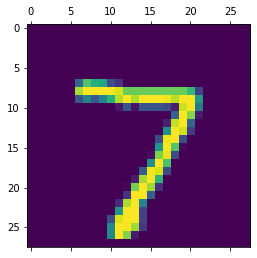

In [96]:
X, y = test_dataloader.dataset[0]
plt.matshow(X.data[0])

In [97]:
model.eval()
pred = model(X)
pred.argmax()

tensor(7)

In [98]:
model.eval()
all_preds = torch.tensor([])
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_preds = torch.cat((all_preds, output))
all_preds = all_preds.argmax(dim=1)
all_preds.data


tensor([7, 2, 1,  ..., 4, 5, 6])

In [99]:
all_test = test_dataloader.dataset.targets

In [100]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataloader.dataset.targets, all_preds.data)
cm

array([[   0,    0,   12,   13,    2,   68,   43,    5,   21,  816],
       [   0, 1115,    2,    2,    0,    2,    4,    2,    8,    0],
       [   0,    8,  928,   19,    7,    4,   13,    9,   38,    6],
       [   0,    1,   18,  924,    0,   26,    1,   10,   18,   12],
       [   0,    1,    4,    0,  904,    0,   13,    3,   10,   47],
       [   0,    2,    3,   24,   11,  785,   17,    4,   33,   13],
       [   0,    3,    4,    1,    7,   13,  922,    2,    2,    4],
       [   0,    6,   24,    7,    7,    0,    0,  946,    2,   36],
       [   0,    8,    6,   20,    8,   24,   10,   12,  875,   11],
       [   0,    5,    2,   12,   19,    9,    0,   18,   11,  933]])

Text(69.0, 0.5, 'Truth')

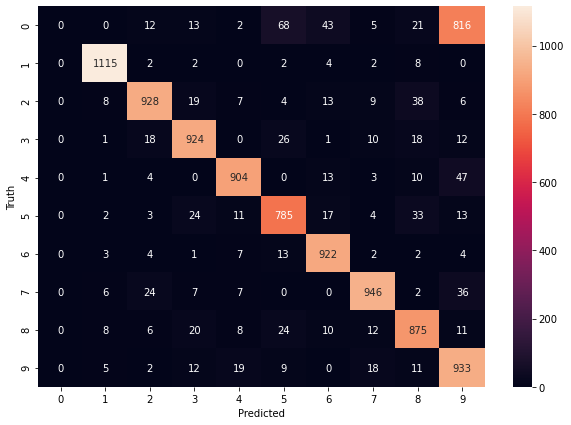

In [101]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')